In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.stats import linregress
import os
import json
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
# Definir parámetros de tiempo desde el archivo .env
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

In [3]:
# Función para obtener archivos que contienen un patrón específico en un directorio
def obtener_archivos_corr_length(directorio, patron="corr_length_real_inverse"):
    archivos = os.listdir(directorio)
    archivos_coincidentes = [os.path.join(directorio, archivo) for archivo in archivos if patron in archivo]
    return archivos_coincidentes

In [4]:
# Definir rutas de los directorios
ruta_strong_mu0 = '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_0'
ruta_strong_mu1 = '/media/erick/TOSHIBA EXT/results_06032025/strong_allee/mu_1'
ruta_weak_mu0 = '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0'
ruta_weak_mu1 = '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_1'

In [5]:
# Obtener listas de archivos desde cada directorio
corr_length_strong_mu0 = obtener_archivos_corr_length(ruta_strong_mu0)
corr_length_strong_mu1 = obtener_archivos_corr_length(ruta_strong_mu1)
corr_length_weak_mu0 = obtener_archivos_corr_length(ruta_weak_mu0)
corr_length_weak_mu1 = obtener_archivos_corr_length(ruta_weak_mu1)

In [6]:
# Función para cargar y graficar archivos
def plot_correlation(corr_length_strong_mu0, corr_length_strong_mu1, corr_length_weak_mu0, corr_length_weak_mu1, title):
    # Ordenar las listas alfabéticamente
    corr_length_strong_mu0.sort()
    corr_length_strong_mu1.sort()
    corr_length_weak_mu0.sort()
    corr_length_weak_mu1.sort()

    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas)
    num_plots = min(len(corr_length_strong_mu0), len(corr_length_strong_mu1), len(corr_length_weak_mu0), len(corr_length_weak_mu1))

    for i in range(num_plots):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura

        files_to_plot = [
            ("Strong μ=0", corr_length_strong_mu0[i]),
            ("Strong μ=1", corr_length_strong_mu1[i]),
            ("Weak μ=0", corr_length_weak_mu0[i]),
            ("Weak μ=1", corr_length_weak_mu1[i])
        ]

        for label, file_path in files_to_plot:
            try:
                data = np.loadtxt(file_path)
                x, y = data[:, 0], data[:, 1]
                plt.plot(x, y, linestyle='-', label=label)
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        # Obtener el nombre del archivo sin la extensión
        base_name = os.path.basename(corr_length_strong_mu0[i])
        file_name_without_ext = os.path.splitext(base_name)[0]

        # Dividir el nombre del archivo en segmentos utilizando el guion bajo como separador
        segments = file_name_without_ext.split('_')

        # Extraer los últimos 3 segmentos y unirlos con guion bajo
        title_segments = '_'.join(segments[-3:])
        title_segments = ''.join(title_segments[+8:])

        plt.xlabel("Distancia (r)", fontsize=12)  # Etiqueta del eje X
        plt.ylabel("g(r)", fontsize=12)  # Etiqueta del eje Y
        plt.title(f"{title} - {title_segments}", fontsize=14)  # Título de la gráfica
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)  # Añadir cuadrícula con líneas punteadas
        plt.tight_layout()  # Ajustar el diseño para evitar recortes
        plt.show()


In [7]:
def plot_correlation_loglog(corr_length_strong_mu0, corr_length_strong_mu1, corr_length_weak_mu0, corr_length_weak_mu1, title):
    # Ordenar las listas alfabéticamente
    corr_length_strong_mu0.sort()
    corr_length_strong_mu1.sort()
    corr_length_weak_mu0.sort()
    corr_length_weak_mu1.sort()

    # Diccionario para almacenar los resultados
    resultados_regresion = {}

    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas)
    num_plots = min(len(corr_length_strong_mu0), len(corr_length_strong_mu1), len(corr_length_weak_mu0), len(corr_length_weak_mu1))

    for i in range(num_plots):
        plt.figure(figsize=(7, 6))  # Tamaño de la figura
        
        files_to_plot = [
            ("Strong μ=0", corr_length_strong_mu0[i]),
            ("Strong μ=1", corr_length_strong_mu1[i]),
            ("Weak μ=0", corr_length_weak_mu0[i]),
            ("Weak μ=1", corr_length_weak_mu1[i])
        ]

        for label, file_path in files_to_plot:
            try:
                data = np.loadtxt(file_path)
                x, y = data[:, 0], data[:, 1]
                
                # Filtrar valores donde x y y sean mayores que 0
                valid_indices = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
                x, y = x[valid_indices], y[valid_indices]
                
                # Verificar si hay suficientes datos para hacer la regresión
                if len(x) > 1:
                    # Gráfico log-log
                    plt.loglog(x, y, linestyle='-', label=label)
                    
                    # Ajuste lineal en escala log-log
                    log_x = np.log(x)
                    log_y = np.log(y)
                    
                    if np.all(np.isfinite(log_x)) and np.all(np.isfinite(log_y)):
                        slope, intercept, _, _, _ = linregress(log_x, log_y)
                        
                        # Guardar valores en el diccionario
                        resultados_regresion[label] = {
                            "m": round(slope, 4),
                            "b": round(intercept, 4),
                            "funcion": f"g(r) ≈ e^{intercept:.4f} * r^{slope:.4f}"
                        }
                        
                        # Imprimir valores de m y b y la ecuación de ajuste
                        print(f"{label}: m = {slope:.4f}, b = {intercept:.4f}")
                        print(f"Función de aproximación: g(r) ≈ e^{intercept:.4f} * r^{slope:.4f}")
                        
                        # Graficar la recta ajustada en log-log
                        fit_y = np.exp(intercept) * x ** slope
                        plt.loglog(x, fit_y, linestyle='--', label=f"Fit: g(r) ≈ e^{intercept:.2f} * r^{slope:.2f}")
                else:
                    print(f"{label}: No hay suficientes datos válidos para la regresión log-log.")
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        plt.xlabel("Distancia (r) [log]")
        plt.ylabel("g(r) [log]")
        plt.title(f"{title} - Log-Log")
        plt.grid(True, which="both", linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.tight_layout()  # Ajustar el diseño para evitar recortes
        plt.show()
    
    # Guardar el diccionario en un archivo JSON
    with open("resultados_regresion.json", "w") as file:
        json.dump(resultados_regresion, file, indent=4)
    
    return resultados_regresion

In [8]:
def plot_correlation_with_fit(corr_length_strong_mu0, corr_length_strong_mu1, corr_length_weak_mu0, corr_length_weak_mu1, title, fit_results_file="resultados_regresion.json"):
    # Cargar los resultados de la regresión desde el archivo JSON
    with open(fit_results_file, "r") as file:
        fit_results = json.load(file)
    
    # Ordenar las listas alfabéticamente
    corr_length_strong_mu0.sort()
    corr_length_strong_mu1.sort()
    corr_length_weak_mu0.sort()
    corr_length_weak_mu1.sort()

    # Determinar la cantidad de archivos a graficar (mínimo de todas las listas)
    num_plots = min(len(corr_length_strong_mu0), len(corr_length_strong_mu1), len(corr_length_weak_mu0), len(corr_length_weak_mu1))

    for i in range(num_plots):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        files_to_plot = [
            ("Strong μ=0", corr_length_strong_mu0[i]),
            ("Strong μ=1", corr_length_strong_mu1[i]),
            ("Weak μ=0", corr_length_weak_mu0[i]),
            ("Weak μ=1", corr_length_weak_mu1[i])
        ]

        for label, file_path in files_to_plot:
            try:
                data = np.loadtxt(file_path)
                x, y = data[:, 0], data[:, 1]
                plt.plot(x, y, linestyle='-', label=label)
                
                # Graficar la función de aproximación si está en los resultados
                if label in fit_results:
                    m = fit_results[label]["m"]
                    b = fit_results[label]["b"]
                    fit_y = np.exp(b) * x ** m
                    plt.plot(x, fit_y, linestyle='--', label=f"Fit: g(r) ≈ e^{b:.2f} * r^{m:.2f}")
            except Exception as e:
                print(f"Error al cargar {file_path}: {e}")

        plt.xlabel("Distancia (r)", fontsize=12)  # Etiqueta del eje X
        plt.ylabel("g(r)", fontsize=12)  # Etiqueta del eje Y
        plt.title(f"{title}", fontsize=14)  # Título de la gráfica
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)  # Añadir cuadrícula con líneas punteadas
        plt.tight_layout()  # Ajustar el diseño para evitar recortes
        plt.show()

Strong μ=0: m = 0.4169, b = 2.3099
Función de aproximación: g(r) ≈ e^2.3099 * r^0.4169
Strong μ=1: m = 0.4155, b = 2.2941
Función de aproximación: g(r) ≈ e^2.2941 * r^0.4155
Weak μ=0: m = 0.4360, b = 2.3109
Función de aproximación: g(r) ≈ e^2.3109 * r^0.4360
Weak μ=1: m = 0.4517, b = 2.3937
Función de aproximación: g(r) ≈ e^2.3937 * r^0.4517


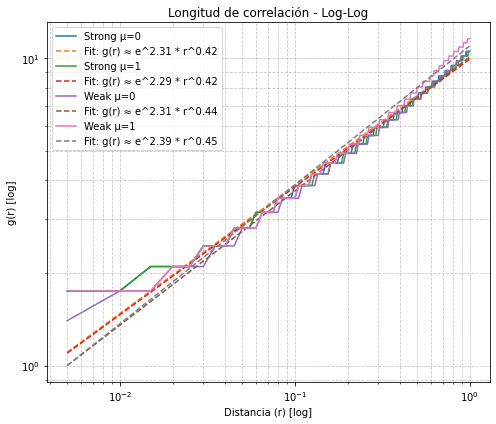

Strong μ=0: m = 0.4162, b = 2.2793
Función de aproximación: g(r) ≈ e^2.2793 * r^0.4162
Strong μ=1: m = 0.4380, b = 2.3404
Función de aproximación: g(r) ≈ e^2.3404 * r^0.4380
Weak μ=0: m = 0.4275, b = 2.3081
Función de aproximación: g(r) ≈ e^2.3081 * r^0.4275
Weak μ=1: m = 0.4577, b = 2.3968
Función de aproximación: g(r) ≈ e^2.3968 * r^0.4577


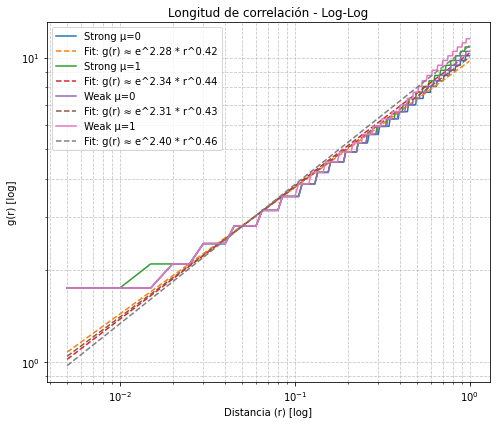

Strong μ=0: m = 0.4052, b = 2.2734
Función de aproximación: g(r) ≈ e^2.2734 * r^0.4052
Strong μ=1: m = 0.4097, b = 2.2471
Función de aproximación: g(r) ≈ e^2.2471 * r^0.4097
Weak μ=0: m = 0.4199, b = 2.2917
Función de aproximación: g(r) ≈ e^2.2917 * r^0.4199
Weak μ=1: m = 0.4214, b = 2.3372
Función de aproximación: g(r) ≈ e^2.3372 * r^0.4214


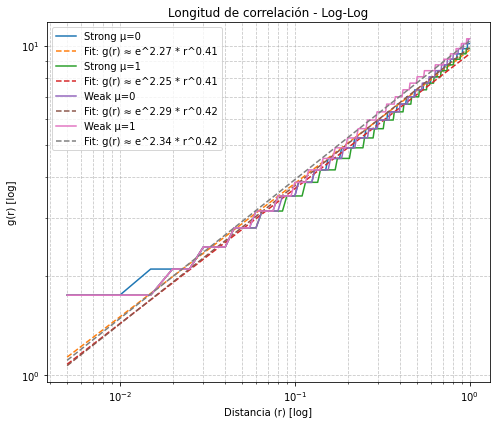

Strong μ=0: m = 0.4487, b = 2.3747
Función de aproximación: g(r) ≈ e^2.3747 * r^0.4487
Strong μ=1: m = 0.4543, b = 2.3983
Función de aproximación: g(r) ≈ e^2.3983 * r^0.4543
Weak μ=0: m = 0.4236, b = 2.3098
Función de aproximación: g(r) ≈ e^2.3098 * r^0.4236
Weak μ=1: m = 0.4533, b = 2.4106
Función de aproximación: g(r) ≈ e^2.4106 * r^0.4533


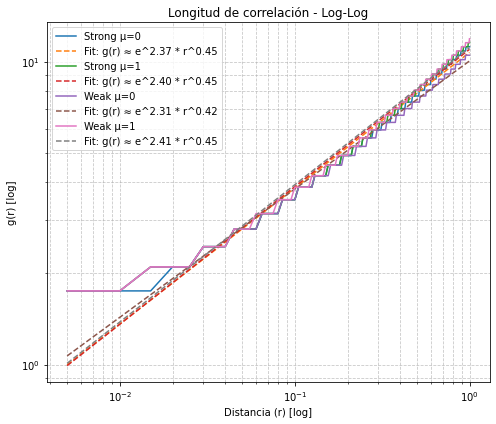

Strong μ=0: m = 0.4330, b = 2.3354
Función de aproximación: g(r) ≈ e^2.3354 * r^0.4330
Strong μ=1: m = 0.4306, b = 2.3058
Función de aproximación: g(r) ≈ e^2.3058 * r^0.4306
Weak μ=0: m = 0.4176, b = 2.2940
Función de aproximación: g(r) ≈ e^2.2940 * r^0.4176
Weak μ=1: m = 0.4207, b = 2.3286
Función de aproximación: g(r) ≈ e^2.3286 * r^0.4207


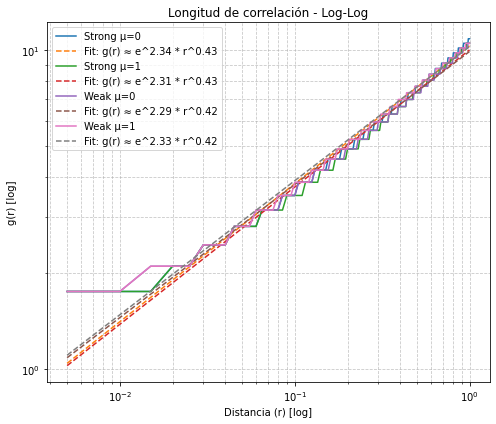

Strong μ=0: m = 0.4376, b = 2.3508
Función de aproximación: g(r) ≈ e^2.3508 * r^0.4376
Strong μ=1: m = 0.4295, b = 2.3104
Función de aproximación: g(r) ≈ e^2.3104 * r^0.4295
Weak μ=0: m = 0.4108, b = 2.2850
Función de aproximación: g(r) ≈ e^2.2850 * r^0.4108
Weak μ=1: m = 0.4426, b = 2.4018
Función de aproximación: g(r) ≈ e^2.4018 * r^0.4426


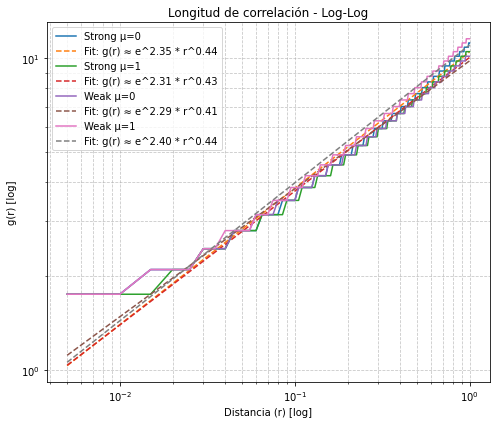

{'Strong μ=0': {'m': 0.4376,
  'b': 2.3508,
  'funcion': 'g(r) ≈ e^2.3508 * r^0.4376'},
 'Strong μ=1': {'m': 0.4295,
  'b': 2.3104,
  'funcion': 'g(r) ≈ e^2.3104 * r^0.4295'},
 'Weak μ=0': {'m': 0.4108,
  'b': 2.285,
  'funcion': 'g(r) ≈ e^2.2850 * r^0.4108'},
 'Weak μ=1': {'m': 0.4426,
  'b': 2.4018,
  'funcion': 'g(r) ≈ e^2.4018 * r^0.4426'}}

In [9]:
# Llamar a la función de graficación con las listas de archivos y un título
plot_correlation_loglog(corr_length_strong_mu0, corr_length_strong_mu1, corr_length_weak_mu0, corr_length_weak_mu1, "Longitud de correlación")

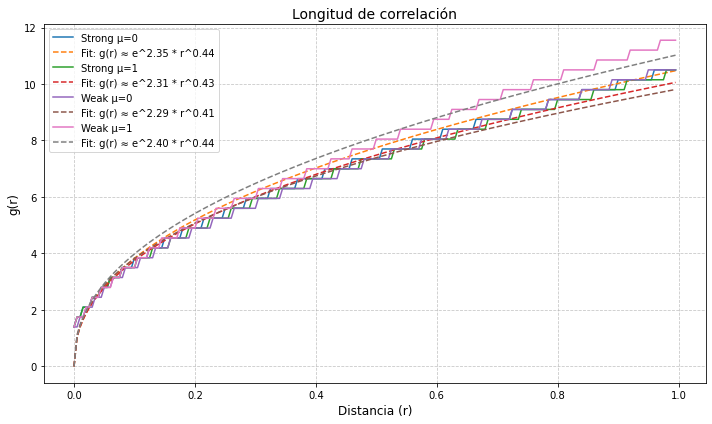

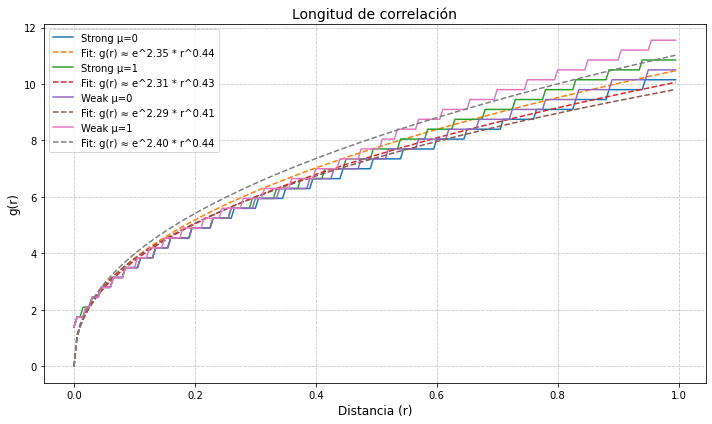

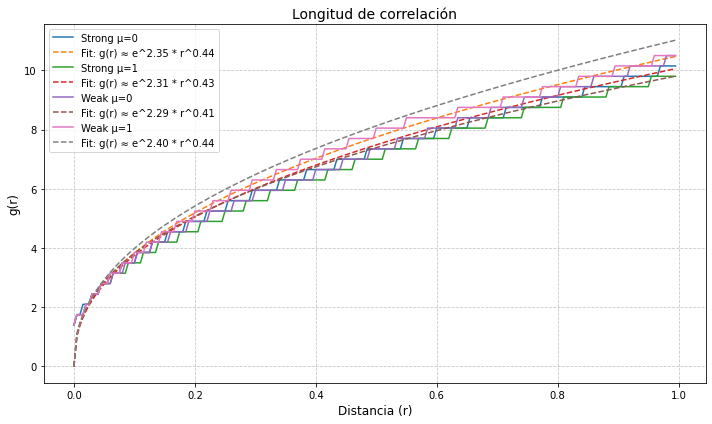

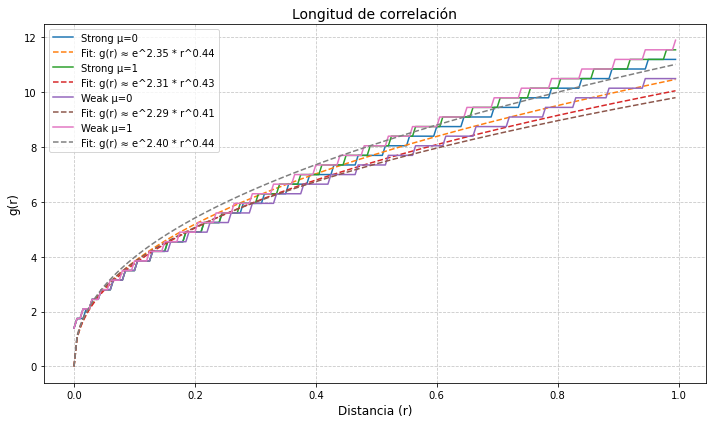

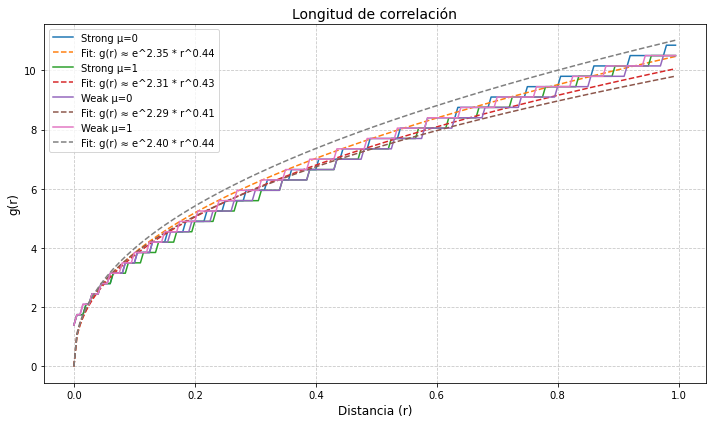

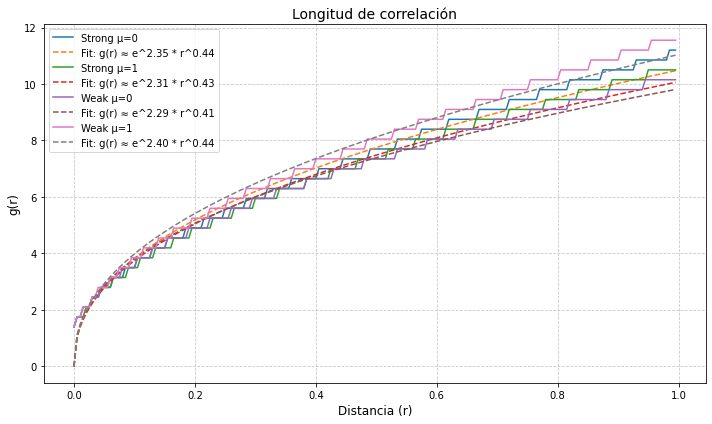

In [10]:
# Llamar a la función con los archivos de correlación y el título
plot_correlation_with_fit(corr_length_strong_mu0, corr_length_strong_mu1, corr_length_weak_mu0, corr_length_weak_mu1, "Longitud de correlación")